In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, hamming_loss

In [2]:
# Directory containing your CSV files
data_dir = 'C:\\Users\\artur\\Desktop\\Studia\\Projekt inzynierski\\data'

# Read CSV files and stack data
def load_eeg_data(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_dir, filename)
            data = pd.read_csv(filepath)
            all_data.append(data.values)
    
    # Stack all data samples into a single array
    data_array = np.stack(all_data, axis=0)  # Shape: (N, T, C)
    return data_array

In [3]:
data_array = load_eeg_data(data_dir)

# Check the shape of the data
print(f"Data shape: {data_array.shape}")

# Normalize the data
data_array = data_array.astype(np.float32)
data_array = (data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array))  # Normalize to [0, 1]

# Ensure the data is in the format (N, C, T, 1)
N, T, C = data_array.shape
data = data_array.transpose(0, 2, 1)[:, :, :, np.newaxis]  # Shape: (N, C, T, 1)

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)

Data shape: (36, 30999, 19)


In [4]:
class EEGDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        return x, x  # In autoencoder, target is the same as input
    def introduce_anomalies(self, num_anomalies):
        for _ in range(num_anomalies):
            idx = np.random.randint(0, len(self.data))
            # Introduce an anomaly by modifying the input, e.g., adding noise
            self.data[idx] += np.random.randn(*self.data[idx].shape) * 100  # Increase noise

# Create datasets and dataloaders for training and testing
train_dataset = EEGDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = EEGDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # No shuffle for test set

In [5]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, in_channels):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=(1, 5), padding=(0, 2)),  # Output: (N, 16, T, C)
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=(1, 5), padding=(0, 2)),  # Output: (N, 8, T, C)
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 5), padding=(0, 2)),  # Output: (N, 16, T, C)
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=(1, 5), padding=(0, 2)),  # Output: (N, in_channels, T, C)
            nn.Sigmoid()  # Sigmoid to ensure output is in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Define the model

In [6]:
in_channels = data.shape[1]
model = SimpleAutoencoder(in_channels=in_channels)
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training loop

num_epochs = 2000  # Adjust based on your needs
patience = 5
min_delta = 0.000001

previous_loss = float('inf')
epochs_without_improvement = 0

try:
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for x_batch, _ in progress_bar:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            progress_bar.set_postfix(loss=loss.item())

        average_loss = epoch_loss / len(train_dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}')

        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save(model.state_dict(), f'simple_autoencoder_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1}.')

        # Early stopping checks
        if abs(previous_loss - average_loss) < min_delta:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Stopping early at epoch {epoch+1}. Loss has not improved significantly.")
                break
        else:
            epochs_without_improvement = 0

        previous_loss = average_loss

except KeyboardInterrupt:
    print("\nTraining interrupted. Saving model...")
    torch.save(model.state_dict(), 'simple_autoencoder_interrupted.pth')
    print('Model saved after interruption.')

# Save the final model after all epochs if training completes normally
torch.save(model.state_dict(), 'simple_autoencoder_final.pth')
print('Final model saved.')

In [7]:
model = SimpleAutoencoder(in_channels=in_channels)  # Initialize the model
model.load_state_dict(torch.load("simple_autoencoder_final.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully")

Model loaded successfully


In [22]:
def calculate_reconstruction_error(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    all_inputs = []  # Store all inputs for visualization

    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in dataloader:  # No need for labels
            reconstructed = model(inputs)  # Get reconstructed output
            
            # Calculate the reconstruction error (Mean Squared Error)
            mse = torch.mean((inputs - reconstructed) ** 2, dim=[1, 2, 3])  # Mean over all dimensions
            reconstruction_errors.extend(mse.cpu().numpy())  # Store errors
            
            all_inputs.extend(inputs.cpu().numpy())  # Store original inputs

    return np.array(reconstruction_errors), np.array(all_inputs)  # Return inputs along with errors

# Call the function and get reconstruction errors and original inputs
reconstruction_errors, original_inputs = calculate_reconstruction_error(model, test_dataloader)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 1)  # E.g., 95th percentile, now 1 for testing

# Identify anomalies
anomalies = reconstruction_errors > threshold

# Print some information
print(f"Threshold for anomalies: {threshold:.4f}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")

Threshold for anomalies: 0.0001
Number of anomalies detected: 5


In [9]:
# Get indices of the detected anomalies
anomaly_indices = np.where(anomalies)[0]

# Determine the unique samples with anomalies
# Assuming each sample corresponds to a certain index in your dataset
# You can also modify this if your dataset has a different structure

# If each sample is a single time-series, use the index directly
# If each sample consists of multiple entries (e.g., 2D or 3D arrays), adjust accordingly
unique_samples_with_anomalies = set(anomaly_indices)

# Count the number of unique samples containing anomalies
num_unique_samples_with_anomalies = len(unique_samples_with_anomalies)

# Print the results
print(f"Number of unique samples containing anomalies: {num_unique_samples_with_anomalies}")

# Optionally, you can list the indices of the samples containing anomalies
print("Indices of samples with anomalies:", unique_samples_with_anomalies)


Number of unique samples containing anomalies: 5
Indices of samples with anomalies: {0, 1, 2, 3, 5}


https://en.wikipedia.org/wiki/Hamming_distance

https://en.wikipedia.org/wiki/Jaccard_index

Jaccard Similarity: Measures the similarity of the anomaly sets by comparing the intersection over the union of the anomalies.
Hamming Distance: Quantifies the difference in anomaly positions between the two samples.
These metrics help you understand how similar or different the anomaly patterns are between two random EEG samples based on your anomaly detection algorithm.

In [10]:
# Introduce synthetic anomalies
# test_dataset.introduce_anomalies(num_anomalies=20)  # Adjust the number as needed

In [11]:
# Function to find two samples that contain anomalies
def find_anomalous_samples(model, dataloader, threshold):
    model.eval()  # Set model to evaluation mode
    anomalous_samples = []
    indices_with_anomalies = set()  # To keep track of unique indices
    
    # Iterate over the dataloader to find samples with anomalies
    for inputs, _ in dataloader:
        with torch.no_grad():
            reconstructed = model(inputs)
        
        # Calculate reconstruction error (Mean Squared Error)
        mse = torch.mean((inputs - reconstructed) ** 2, dim=[1, 2, 3])
        
        # Convert MSE to numpy array and check for anomalies
        errors = mse.cpu().numpy()
        anomalies = errors > threshold
        
        # Append samples if they contain anomalies and are unique
        for idx in range(len(anomalies)):
            if anomalies[idx] and idx not in indices_with_anomalies:
                anomalous_samples.append(inputs[idx])
                indices_with_anomalies.add(idx)  # Track the index to avoid duplicates
            
            # Stop once we have found two unique samples with anomalies
            if len(anomalous_samples) >= 2:
                break
        
        if len(anomalous_samples) >= 2:
            break
    
    if len(anomalous_samples) < 2:
        print("Not enough anomalous samples found in the dataset.")
        return None, None
    
    # Return two unique samples with anomalies
    return anomalous_samples[0], anomalous_samples[1]

# Function to compare two anomalous samples
def compare_anomalous_samples(model, sample_1, sample_2, threshold):
    model.eval()  # Set model to evaluation mode
    
    # Forward pass through the model (no need for gradients)
    with torch.no_grad():
        reconstructed_1 = model(sample_1.unsqueeze(0))  # Add batch dimension
        reconstructed_2 = model(sample_2.unsqueeze(0))  # Add batch dimension
    
    # Calculate reconstruction errors (Mean Squared Error)
    mse_1 = torch.mean((sample_1 - reconstructed_1) ** 2, dim=[1, 2, 3])
    mse_2 = torch.mean((sample_2 - reconstructed_2) ** 2, dim=[1, 2, 3])
    
    # Convert MSE to numpy arrays
    errors_1 = mse_1.cpu().numpy()
    errors_2 = mse_2.cpu().numpy()
    
    # Determine if each sample's reconstruction error is an anomaly
    anomalies_1 = errors_1 > threshold
    anomalies_2 = errors_2 > threshold
    
    # Jaccard similarity (intersection over union)
    jaccard_sim = jaccard_score(anomalies_1, anomalies_2, average='binary')
    
    # Hamming distance (number of different positions)
    hamming_dist = hamming_loss(anomalies_1, anomalies_2)
    
    return jaccard_sim, hamming_dist

# Main logic: find and compare anomalous samples
sample_1, sample_2 = find_anomalous_samples(model, test_dataloader, threshold)

if sample_1 is not None and sample_2 is not None:
    jaccard_similarity, hamming_distance = compare_anomalous_samples(model, sample_1, sample_2, threshold)
    
    print(f"Jaccard Similarity: {jaccard_similarity:.4f}")
    print(f"Hamming Distance: {hamming_distance:.4f}")


Jaccard Similarity: 1.0000
Hamming Distance: 0.0000


A Jaccard similarity of 1.0000 and a Hamming distance of 0.0000 indicates that the two samples are identical in terms of their detected anomalies. This means that both samples have the same anomalies at the same positions.

Next Steps
Here are a few suggestions for what you could do next:

Visualize Anomalous Samples: Consider visualizing both anomalous samples to better understand what the anomalies look like. This can help in diagnosing issues or confirming that the detected anomalies are indeed valid.

Analyze Reconstruction Errors: Investigate the reconstruction errors for different samples, especially those not classified as anomalies. This can give insights into the model's performance.

Experiment with Thresholds: You could experiment with different thresholds for anomaly detection to see how it affects the number of detected anomalies. This can help fine-tune your anomaly detection system.

Add More Evaluation Metrics: Depending on your needs, you might want to compute additional metrics, such as precision, recall, or F1-score, if you have ground truth labels for anomalies.

Test on New Data: If possible, try applying your model to new data to evaluate its generalization performance and see if it effectively identifies anomalies.

Train with More Data: If your dataset is limited, consider gathering more training data or using data augmentation techniques to improve the model's performance.

Shape of image at index 0: (19, 30999, 1)
Shape of image at index 1: (19, 30999, 1)
Shape of image at index 2: (19, 30999, 1)
Shape of image at index 3: (19, 30999, 1)
Shape of image at index 5: (19, 30999, 1)


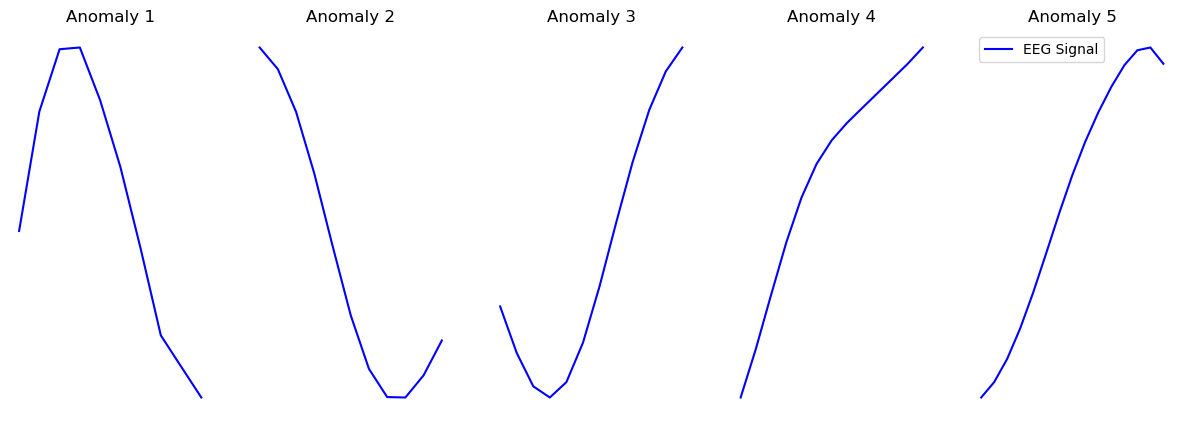

In [12]:
# Visualize the detected anomalies 
anomaly_indices = np.where(anomalies)[0]
n_samples = min(5, len(anomaly_indices))  # Show at most 5 samples

# Create a figure for visualization
plt.figure(figsize=(15, 5))
for i, index in enumerate(anomaly_indices[:n_samples]):
    plt.subplot(1, n_samples, i + 1)
    plt.title(f'Anomaly {i + 1}')
    
    # Extract the anomalous image
    image = original_inputs[index]

    # Print the shape of the image for debugging
    print(f"Shape of image at index {index}: {image.shape}")

    # Selecting the first channel for visualization (adjust if needed)
    image = image[0, :, :]  # Select the first channel (shape: [30999, 1])

    # Check if there's a singleton dimension, and squeeze it
    if image.ndim == 2 and image.shape[1] == 1:
        image = image.squeeze(1)  # Remove the second dimension

    # Determine the time slice around the anomaly
    anomaly_position = index
    start = max(0, anomaly_position - 10)  # 100 points before the anomaly
    end = min(anomaly_position + 10, len(image))  # 100 points after the anomaly

    # Adjust the start index if we don't have 100 points before the anomaly
    if anomaly_position < 10:
        start = 0  # Ensure we start at the beginning if not enough points before
    # Adjust the end index if we don't have 100 points after the anomaly
    if anomaly_position + 10 >= len(image):
        end = len(image)  # Ensure we end at the last point if not enough points after
    
    # Ensure we are within bounds
    time_slice = slice(start, end)  # Get the slice for visualization
    image_slice = image[time_slice]  # Extract the relevant slice

    # Plot the entire slice in blue
    plt.plot(image_slice, color='blue', label='EEG Signal')  # Use plot for one-dimensional data

    # Color the segments of the signal corresponding to the anomalies
    for anomaly in np.where(anomalies[start:end])[0]:  # Iterate through the anomalies in the slice
        plt.plot(np.arange(anomaly + start, anomaly + start + 1), image_slice[anomaly], color='red', linewidth=2)

    plt.axis('off')  # Hide axes
plt.legend()  # Show legend
plt.show()


Shape of image at index 0: (19, 30999, 1)
Shape of image at index 1: (19, 30999, 1)
Shape of image at index 2: (19, 30999, 1)
Shape of image at index 3: (19, 30999, 1)
Shape of image at index 5: (19, 30999, 1)


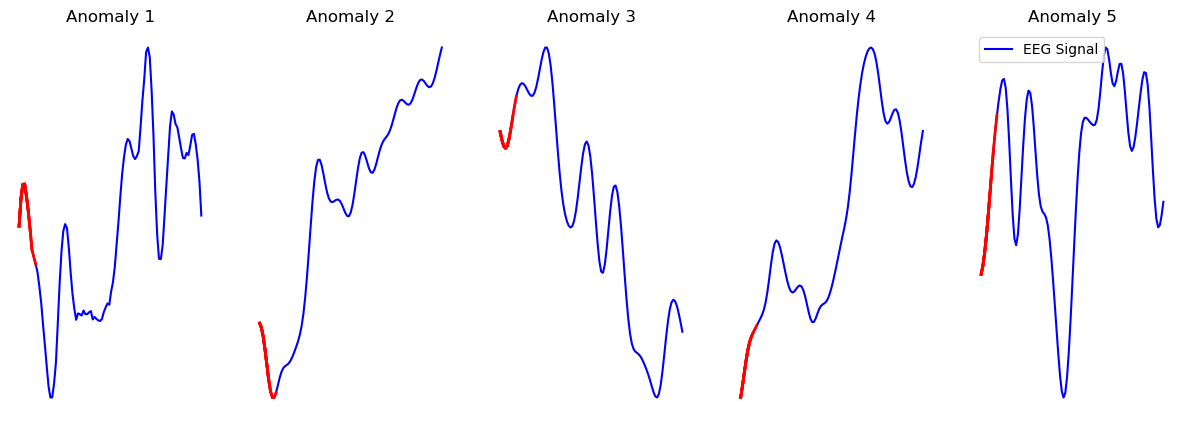

In [23]:
# Visualize the detected anomalies 
anomaly_indices = np.where(anomalies)[0]
n_samples = min(5, len(anomaly_indices))  # Show at most 5 samples

# Create a figure for visualization
plt.figure(figsize=(15, 5))
for i, index in enumerate(anomaly_indices[:n_samples]):
    plt.subplot(1, n_samples, i + 1)
    plt.title(f'Anomaly {i + 1}')
    
    # Extract the anomalous image
    image = original_inputs[index]

    # Print the shape of the image for debugging
    print(f"Shape of image at index {index}: {image.shape}")

    # Selecting the first channel for visualization (adjust if needed)
    image = image[0, :, :]  # Select the first channel (shape: [30999, 1])

    # Check if there's a singleton dimension, and squeeze it
    if image.ndim == 2 and image.shape[1] == 1:
        image = image.squeeze(1)  # Remove the second dimension

    # Determine the time slice around the anomaly
    anomaly_position = index
    start = max(0, anomaly_position - 100)  # 10 points before the anomaly
    end = min(anomaly_position + 100, len(image))  # 10 points after the anomaly

    # Adjust the start index if we don't have enough points before the anomaly
    if anomaly_position < 100:
        start = 0  # Ensure we start at the beginning if not enough points before
    # Adjust the end index if we don't have enough points after the anomaly
    if anomaly_position + 100 >= len(image):
        end = len(image)  # Ensure we end at the last point if not enough points after

    # Ensure we are within bounds
    time_slice = slice(start, end)  # Get the slice for visualization
    image_slice = image[time_slice]  # Extract the relevant slice

    # Plot the entire slice in blue
    plt.plot(image_slice, color='blue', label='EEG Signal')  # Use plot for one-dimensional data

    # Color the segments of the signal corresponding to the anomalies
    for anomaly in np.where(anomalies[start:end])[0]:  # Iterate through the anomalies in the slice
        # Define the segment for the anomaly
        anomaly_start = max(0, anomaly + start - 5)  # Extend segment start slightly before anomaly
        anomaly_end = min(len(image_slice), anomaly + start + 5)  # Extend segment end slightly after anomaly
        plt.plot(np.arange(anomaly_start, anomaly_end), image[anomaly_start:anomaly_end], color='red', linewidth=2)

    plt.axis('off')  # Hide axes
plt.legend()  # Show legend
plt.show()
